In [21]:
import numpy as np
import matplotlib.pyplot as plt
import geoist
from geoist.inversion import geometry
from geoist.pfm import prism, pftrans
from geoist import gridder
from geoist.pfm import giutils
config = {
    "font.family":'Times New Roman',
    "font.size": 10,
    "mathtext.fontset":'stix',
    "font.serif": ['SimSun'],
}
plt.rcParams.update(config)

In [22]:
## 1. generate a model
def gen_grav(zlevel = 0, shape = (64, 64)):

    dx = 6000/8.
    dy = 6000/8.
    dz = 1900/8.
    model = [geometry.Prism(-1000, 1000, -1000, 1000, 500, 1000, {'density': 500}),
            geometry.Prism(-1250, -2750, -1250, -2750, 500, 1000, {'density': 800}),
            geometry.Prism(1250, 2750, 1250, 2750, 500, 1000, {'density': 600})]
    #model = [geometry.Prism(-1000, 1000, -1000, 1000, 500, 1000, {'density': 800})]
    #prism1 = geometry.Prism(-3000+3*dx, -3000+4*dx, -3000+7*dy, -3000+8*dy, 100+4*dz, 100+5*dz, {'density': 2000})
    #prism2 = geometry.Prism(-3000+2*dx, -3000+3*dx, -3000+2*dy, -3000+3*dy, 100+4*dz, 100+5*dz, {'density': 2000})
    #model = [prism1,prism2]
    nzyx = [8,8,8]
    source_volume = [-3000, 3000, -3000, 3000, 100, 2000]
    x = np.linspace(-3150, 3150, num=64, endpoint=True)
    xp, yp = np.meshgrid(x, x)
    zp = np.zeros_like(xp)+zlevel
    
    #xp, yp, zp = gridder.regular((-3200, 3200, -3200, 3200), shape, z=zlevel)
    field0 = prism.gz(xp.flatten(), yp.flatten(), zp.flatten(), model)
    field1 = giutils.contaminate(field0, 0.1, percent = True)
    return field0, field1, xp.flatten(), yp.flatten(), zp.flatten()

#---------位场频率域向下延拓----------#
def down_conn(x, y, data, shape, z_conn, pfilter=0.0):
    x1 = x.min()
    x2 = x.max()
    y1 = y.min()
    y2 = y.max()    
    x0 = (x1+x2)/2.0
    y0 = (y1+y2)/2.0
    a = np.abs(x1-x2)/2.0
    b = np.abs(y1-y2)/2.0
    nx, ny = shape
    dx = (x.max() - x.min())/(nx - 1)
    dy = (y.max() - y.min())/(ny - 1)
    
    complex1 = 0+1j
    # Pad the array with the edge values to avoid instability
    padded, padx, pady = _pad_data(data, shape)
    kx, ky = _fftfreqs(x, y, shape, padded.shape)
    kz = np.sqrt(kx**2 + ky**2)
    
    filter_conn = np.exp(-2.0*np.pi*z_conn*kz)
    filter_conn = filter_conn/(np.exp(-4.0*np.pi*z_conn*kz)+pfilter*np.power(2.0*np.pi*kz,4))
    
    cuv = np.fft.fft2(padded)

    amz = filter_conn*cuv
    
    nxe, nye = padded.shape
    M_left=(nxe-nx)/2+1
    M_right=M_left+nx-1
    N_down=(nye-ny)/2+1
    N_up=N_down+ny-1

    XXmin=x.min()-dx*(M_left-1)
    XXmax=x.max()+dx*(nxe-M_right)
    YYmin=y.min()-dy*(N_down-1)
    YYmax=y.max()+dy*(nye-N_up)
    resz = np.real(np.fft.ifft2(amz))
    conn_data = resz[padx: padx + nx, pady: pady + ny].ravel()
    return conn_data

def _pad_data(data, shape):
    n = _nextpow2(np.max(shape))
    nx, ny = shape
    padx = (n - nx)//2
    pady = (n - ny)//2
    padded = np.pad(data.reshape(shape), ((padx, padx), (pady, pady)),
                       mode='linear_ramp') #edge
    return padded, padx, pady

def _nextpow2(i):
    buf = np.ceil(np.log(i)/np.log(2))+1
    return int(2**buf)

def _fftfreqs(x, y, shape, padshape):
    """
    Get two 2D-arrays with the wave numbers in the x and y directions.
    """
    nx, ny = shape
    dx = (x.max() - x.min())/(nx - 1)
    fx = 2*np.pi*np.fft.fftfreq(padshape[0], dx)
    dy = (y.max() - y.min())/(ny - 1)
    fy = 2*np.pi*np.fft.fftfreq(padshape[1], dy)
    return np.meshgrid(fy, fx)[::-1]

Comparison for the downward continuation method!
[-3150. -3050. -2950. ...  2950.  3050.  3150.]
[-3150. -3150. -3150. ...  3150.  3150.  3150.]


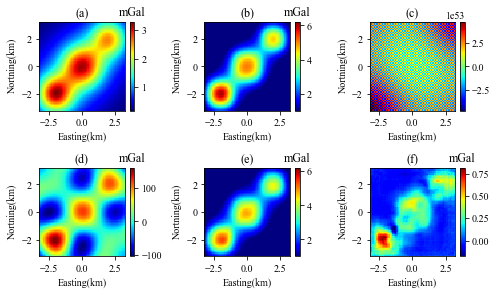

In [24]:
import matplotlib
if __name__ == '__main__':
    
    print('Comparison for the downward continuation method!')
    shape = (64, 64)
    zlevel =  500
    g0, g0_noise, x, y, z0 = gen_grav(-1*zlevel, shape)
    gz, gz_noise, x, y, z1 = gen_grav(0, shape)
    g0_up = pftrans.upcontinue(x, y, gz, shape=(64, 64), height=zlevel)
    upgrd = np.array(g0).reshape(shape)
    #upgrd = np.array(gz).reshape(shape)
    print(x)
    print(y)
    dfm0 = down_conn(x, y, upgrd, shape, zlevel, 0.0)
    dfm1 = down_conn(x, y, upgrd, shape, zlevel, 1.0)
    dfm10 = down_conn(x, y, upgrd, shape, zlevel, 100.0)
    dfm100 = down_conn(x, y, upgrd, shape, zlevel, 10000.0)
    #for i in range(24):
        #dfm0 = down_conn(x, y, dfm0, shape, zlevel, 0.0)
        #dfm1 = down_conn(x, y, dfm1, shape, zlevel, 1.0)
        #dfm10 = down_conn(x, y, dfm10, shape, zlevel, 100.0)
        #dfm100 = down_conn(x, y, dfm100, shape, zlevel, 1000.0)   
    x = np.linspace(-3150, 3150, num=64, endpoint=True)/1000
    X, Y = np.meshgrid(x, x)
# #---------------结果对比可视化-------------------------# 
    norm = matplotlib.colors.Normalize(vmin=1, vmax=6.2)
    plt.figure(figsize=(7,4.2))
    ax1 = plt.subplot(231)
    upgrd = np.array(g0).reshape(shape)
    plt.pcolormesh(X, Y, upgrd, cmap='jet')
    plt.title('(a)')
    plt.xlabel('Easting(km)')
    plt.ylabel('Nortning(km)')
    cb = plt.colorbar()
    cb.ax.set_title('mGal')
    ax2 = plt.subplot(232)
    dfgrd = np.array(gz).reshape(shape)
    plt.pcolormesh(X, Y, dfgrd, cmap='jet', norm = norm)    
    plt.title('(b)')
    plt.xlabel('Easting(km)')
    plt.ylabel('Nortning(km)')
    cb = plt.colorbar()
    cb.ax.set_title('mGal')
    
    ax3 = plt.subplot(233)
    diffgrd = np.array(dfm0).reshape(shape)
    plt.pcolormesh(X, Y, diffgrd, cmap='jet') 
    plt.title('(c)')
    plt.xlabel('Easting(km)')
    plt.ylabel('Nortning(km)')

    cb = plt.colorbar()
    #cb.ax.set_title('mGal')
    
    ax4 = plt.subplot(234)
    dfmgrd = np.array(dfm10).reshape(shape)
    plt.pcolormesh(X, Y, dfmgrd, cmap='jet')   
    plt.title('(d)')
    plt.xlabel('Easting(km)')
    plt.ylabel('Nortning(km)')
    cb = plt.colorbar()
    cb.ax.set_title('mGal')


    data = np.load('noisefree_real.npy')
    
    ax5 = plt.subplot(235)
    dfmgrd = np.array(dfm100).reshape(shape)
    plt.pcolormesh(X, Y, data, cmap='jet', norm = norm)
    plt.title('(e)')
    plt.xlabel('Easting(km)')
    plt.ylabel('Nortning(km)')
    cb = plt.colorbar()
    cb.ax.set_title('mGal')
    
    ax6 = plt.subplot(236)
    dfmgrd = np.array(dfm100).reshape(shape)
    plt.pcolormesh(X, Y, dfgrd-data, cmap='jet')
    plt.title('(f)')
    plt.xlabel('Easting(km)')
    plt.ylabel('Nortning(km)')
    plt.tight_layout()
    cb = plt.colorbar()
    cb.ax.set_title('mGal')
    plt.tight_layout()
    plt.savefig("comparison.pdf")
    plt.savefig("comparison.png", dpi=300)
    
    mse_df = np.sum((dfmgrd.flatten()-dfgrd.flatten())**2)/(64*64)